In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, avg, lit, udf, count, stddev
from pyspark.sql.types import FloatType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.stat import Summarizer
from functools import reduce
from datetime import datetime
from data_utils import get_date_range, get_data, clear_data
import matplotlib
import matplotlib.pyplot as plt
import pandas
import os
import numpy as np
import json
import requests

In [2]:
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

In [ ]:
# Sentiment 140 Dataset (Tweet + sentiment)
df = sqlContext.read.format('com.databricks.spark.csv').options(header='false').load('training.1600000.processed.noemoticon.csv', schema='Category INTEGER, Timestamp LONG, Date STRING, Query STRING, Username STRING, Text STRING')
df.printSchema()

In [ ]:
# Show categories (4 = positive, 0 = negative)
df = df.where(col("Category").isNotNull())
df.groupBy("Category").count().orderBy(col("count").desc()).show()

In [ ]:
def create_model(regParam, vocabSize, elasticNetParam, df):
    
    print("regParam: %f, vocabSize: %d, elasticNetParam: %f" % (regParam, vocabSize, elasticNetParam))

    # Tokenizer
    regexTokenizer = RegexTokenizer(inputCol="Text", outputCol="words", pattern="@\\S*|\\W|http\\S*")

    # Stop words
    stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")
    stopwordsRemover.setStopWords(StopWordsRemover.loadDefaultStopWords("english"))

    # Bag of words
    countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=vocabSize, minDF=5)

    # String indexer
    label_stringIdx = StringIndexer(inputCol = "Category", outputCol = "label")

    # Apply the pipeline
    pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
    pipelineFit = pipeline.fit(df)
    dataset = pipelineFit.transform(df)
    
    # Training and test splits
    (trainingData, testData) = dataset.randomSplit([0.9, 0.1], seed = 100)
    
    # Train and evaluate the model
    lr = LogisticRegression(maxIter=10, regParam=regParam, elasticNetParam=elasticNetParam)
    model = lr.fit(trainingData)
    predictions = model.transform(testData)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    f1_score = evaluator.evaluate(predictions)
    
    return [model, pipelineFit, trainingData, testData, f1_score]

In [ ]:
# Find best regParam and vocabSize combination
for regParam in [0.0, 0.125, 0.25, 0.5]:
    for vocabSize in [100, 1000, 10000, 100000]:
        model, pipelineFit, trainingData, testData, f1_score = create_model(regParam, vocabSize, 0.0, df)
        print("F1-score: %f" % f1_score)
        
"""
Results 

regParam: 0.000000, vocabSize: 100
F1 Score: 0.645073
regParam: 0.000000, vocabSize: 1000
F1 Score: 0.744660
> regParam: 0.000000, vocabSize: 10000
F1 Score: 0.777977
regParam: 0.000000, vocabSize: 100000
F1 Score: 0.776525
regParam: 0.125000, vocabSize: 100
F1 Score: 0.644638
regParam: 0.125000, vocabSize: 1000
F1 Score: 0.743337
regParam: 0.125000, vocabSize: 10000
F1 Score: 0.775839
regParam: 0.125000, vocabSize: 100000
F1 Score: 0.777695
regParam: 0.250000, vocabSize: 100
F1 Score: 0.643508
regParam: 0.250000, vocabSize: 1000
F1 Score: 0.742042
regParam: 0.250000, vocabSize: 10000
F1 Score: 0.774576
regParam: 0.250000, vocabSize: 100000
F1 Score: 0.777197
regParam: 0.500000, vocabSize: 100
F1 Score: 0.643352
regParam: 0.500000, vocabSize: 1000
F1 Score: 0.740815
regParam: 0.500000, vocabSize: 10000
F1 Score: 0.772755
regParam: 0.500000, vocabSize: 100000
F1 Score: 0.775840

"""


In [ ]:
model, pipelineFit, trainingData, testData, f1_score = create_model(0.0, 10000, 0.0, df)

In [ ]:
test_df = spark.createDataFrame(
    [
        ("name", "Your code sucks and you will never get a job."),
        ("name", "I love your library, very excellent code sir."),
        ("name", "Why did you choose Java? It is so f***ing slow and terrible."),
        ("name", "Yes, thank you very much friend."),
        ("name", "I should be around 0.5."),
    ],
    ["Name", "Text"]
)

model.transform(pipelineFit.transform(test_df)).select(col('probability'), col('prediction'), col('Text')).show()

In [ ]:
def get_processed_data(event_df):
    
    event_df.createOrReplaceTempView("events")
    
    # Pull request 
    pullrequest_df = spark.sql("SELECT repo.name as Repo, payload.pull_request.body as Text, payload.pull_request.head.repo.language as Lang FROM events WHERE type = 'PullRequestReviewEvent' AND payload.pull_request.body IS NOT NULL AND payload.pull_request.head.repo.language IS NOT NULL AND CHAR_LENGTH(payload.pull_request.body) > 0")

    # Pull request review
    pullrequestreview_df = spark.sql("SELECT repo.name as Repo, payload.review.body as Text, payload.pull_request.head.repo.language as Lang FROM events WHERE type = 'PullRequestReviewEvent' AND payload.review.body IS NOT NULL AND payload.pull_request.head.repo.language IS NOT NULL AND CHAR_LENGTH(payload.review.body) > 0")

    # Pull request review comment
    pullrequestreviewcomment_df = spark.sql("SELECT repo.name as Repo, payload.comment.body as Text, payload.pull_request.head.repo.language as Lang FROM events WHERE type = 'PullRequestReviewCommentEvent' AND payload.comment.body IS NOT NULL AND payload.pull_request.head.repo.language IS NOT NULL AND CHAR_LENGTH(payload.comment.body) > 0")

    union_df = (pullrequestreviewcomment_df.unionByName(pullrequestreview_df))

    # Sentiment
    union_df = model.transform(pipelineFit.transform(union_df)).select(col('probability'), col('Repo'), col('Text'), col('Lang'))
    union_df = union_df.withColumn("timestamp", lit(dates[0].timestamp()))

    # Pandas
    pd = union_df.toPandas()
    s = pd['probability'].apply(lambda x: pandas.Series(x.toArray()))
    pd['p'] = s[0]
    pd = pd.drop('probability', 1)
    
    return pd

In [ ]:
# Save processed data to ./results/
for day in range(1, 31):
    for hour in range(0, 24):
        dates = [datetime(2021, 4, day, hour)]
        event_df = get_data(dates, spark)
        pd = get_processed_data(event_df)
        pd.to_pickle("results/processed_data_%d_%d_%d_%d.pkl" % (2021, 4, day, hour))
        clear_data()

In [3]:
# Load processed data
pkl_files = [pkl for pkl in os.listdir("./results") if pkl[-3:] == "pkl"]
processed_dfs = list(map(lambda pkl: spark.createDataFrame(pandas.read_pickle("./results/" + pkl)), pkl_files))
processed_df = reduce(lambda a, b: a.unionByName(b), processed_dfs, processed_dfs[0])

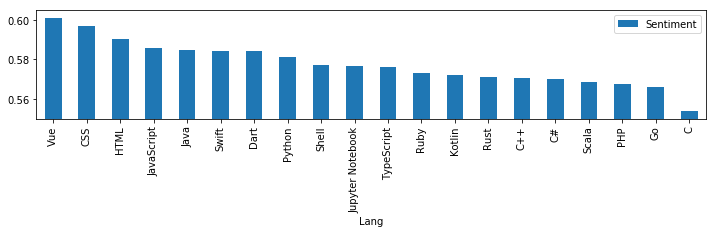

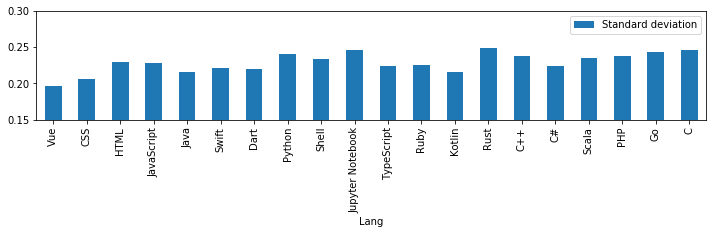

In [4]:
# Plot Language
pd = processed_df.groupBy("Lang").agg(avg("p"),stddev("p"), count("Lang")).orderBy(col("count(Lang)").desc()).toPandas()
pd['Sentiment'] = 1.0 - pd['avg(p)']
pd['Standard deviation'] = pd['stddev_samp(p)']
pd = pd[0:20].sort_values("Sentiment", ascending=False)
pd.plot("Lang", "Sentiment",kind="bar", figsize=(12, 2), ylim=[0.55, 0.605])
pd.plot("Lang", "Standard deviation",kind="bar", figsize=(12, 2), ylim=[0.15, 0.3])


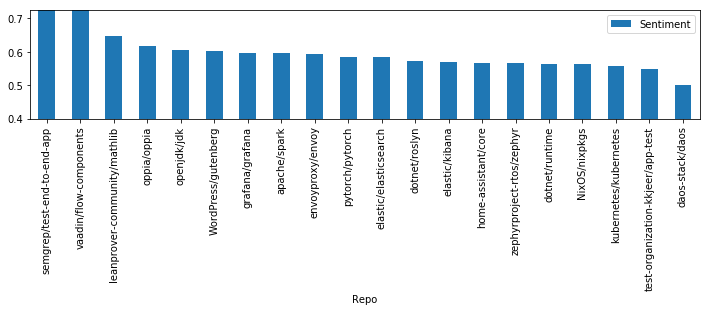

In [5]:
# Plot repositories
pd = processed_df.groupBy("Repo").agg(avg("p"),stddev("p"), count("Repo")).orderBy(col("count(Repo)").desc()).toPandas()
pd['Sentiment'] = 1.0 - pd['avg(p)']
pd = pd[0:20].sort_values("Sentiment", ascending=False)
pd.plot("Repo", "Sentiment", kind="bar", figsize=(12, 2), ylim=[0.4, 0.725])

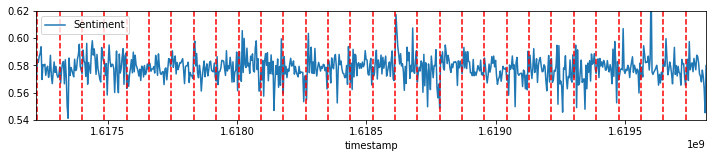

In [6]:
# Plot time of day
pd = processed_df.groupBy("timestamp").agg(avg("p"), stddev("p")).toPandas()
pd['Date'] = pandas.to_datetime(pd['timestamp'], unit='s')
pd['Sentiment'] = 1.0 - pd['avg(p)']
pd = pd.sort_values("timestamp", ascending=False)
ax = pd.plot("timestamp", "Sentiment",figsize=(12, 2), ylim=[0.54, 0.62])
for i in range(1, 31): 
    line_date = datetime(2021, 4, i).timestamp()
    ax.axvline(line_date, color="red", linestyle="--")

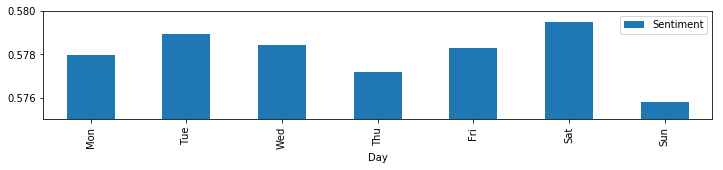

In [10]:
# Plot weekday
pd['Date'] = pandas.to_datetime(pd['timestamp'], unit='s')
days = []
names = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
for i in range(0, 7):
    day_mask = pd['Date'].map(lambda x: x.weekday()) == i
    days.append([names[i], pd[day_mask].mean(0)['Sentiment']])
d_pd = pandas.DataFrame(days)
d_pd.columns = ['Day', 'Sentiment']
d_pd.plot.bar(0, 1, figsize=(12, 2), ylim=[0.575, 0.58])

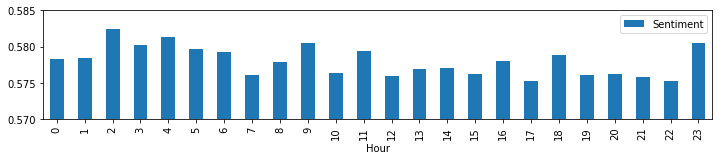

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 57854)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.6/socketserver.py", line 721, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 268, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 241, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 245, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/pysp

In [8]:
# Plot hour of day
pd['Date'] = pandas.to_datetime(pd['timestamp'], unit='s')
hours = []
for i in range(0, 24):
    hour_mask = pd['Date'].map(lambda x: x.hour) == i
    hours.append([i, pd[hour_mask].mean(0)['Sentiment']])
h_pd = pandas.DataFrame(hours)
h_pd.columns = ['Hour', 'Sentiment']
h_pd.plot.bar(0, 1, figsize=(12, 2), ylim=[0.57, 0.585])